In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [3]:
import pyreadr

In [4]:
# Loading the full data

data = pd.read_csv('SVol Benchmarks/quarterlyData_updated.csv')
data_orig = pd.read_csv('data/quarterlyData_updated.csv')

In [ ]:
arfit = pyreadr.read_r(f'SVol Benchmarks/arfit_all_quarterly_4var.RData')['arfit_all'].to_numpy().T
svfit = pyreadr.read_r(f'SVol Benchmarks/svfit_all_quarterly_4var.RData')['svfit_all'].to_numpy().T
volfit = pyreadr.read_r(f'SVol Benchmarks/cov_mat_all_quarterly_4var.RData')['volfit_all'].to_numpy().T

In [34]:
arfit2 = np.load(f'SVol Benchmarks/arfit_all_quarterly_4var_ar2_constvol.npy')
svfit2 = np.load(f'SVol Benchmarks/svfit_all_quarterly_4var_ar2_constvol.npy')

### BVAR Results

In [52]:
bvar_preds_all = pyreadr.read_r(f'SVol Benchmarks/y_pred_all_quarterly_4var_bvar_hor1.RData')['y_pred_hor1'].to_numpy().T
bvar_vol_all = pyreadr.read_r(f'SVol Benchmarks/y_sd_all_quarterly_4var_bvar_hor1.RData')['y_sd_hor1'].to_numpy().T
bvar_cov_mat_all = pyreadr.read_r(f'SVol Benchmarks/cov_mat_all_quarterly_4var_bvar_hor1.RData')['cov_mat_hor1'].to_numpy().T

In [53]:
bvar_vol2_all = bvar_cov_mat_all[:, [0, 4, 7, 9]] ** 0.5

In [21]:
import matplotlib.pyplot as plt

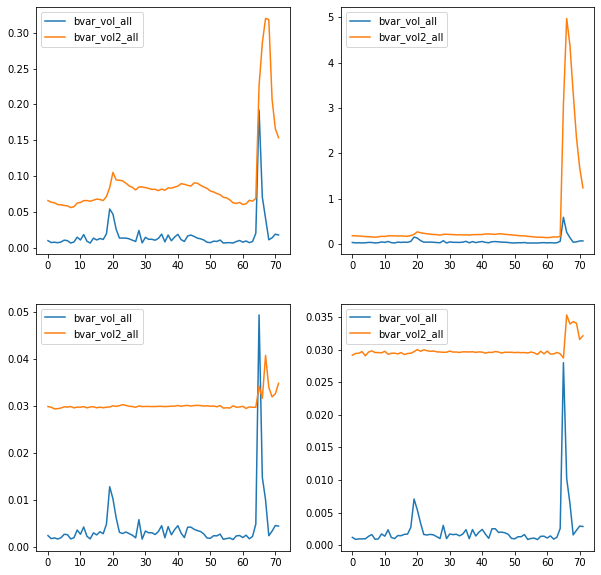

In [55]:
# Create a 2x2 subplots on matplotlib of bvar_vol_all

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
 
# For each subplot, plot bvar_vol_all and bvar_vol2_all for each variable
for i in range(2):
  for j in range(2):
      ax[i, j].plot(bvar_vol_all[:, i*2 + j], label='bvar_vol_all')
      ax[i, j].plot(bvar_vol2_all[:, i*2 + j], label='bvar_vol2_all')
      ax[i, j].legend()

plt.show()


### Quarterly

In [73]:
data = pd.read_csv('SVol Benchmarks/quarterlyData_updated.csv')
data = data[['house_starts', 'unrate', 'GDP', 'inf']]
test_size = 72
window_size = 60

In [74]:
preds_all = np.zeros((test_size, 4))
vol_all = np.zeros((test_size, 4))

In [75]:
for var in range(data.shape[1]):
  for t in range(test_size):
    # Create a training set of size window_size
    y_train = data.iloc[(len(data) - test_size + t - window_size):(len(data) - test_size + t), var]
    # Concat the two lags to get the training set
    Y_train = pd.DataFrame(np.vstack((y_train, y_train.shift(1), y_train.shift(2))).T).dropna()
    Y_train.columns = ['y', 'y_lag1', 'y_lag2']
    X_train = Y_train[['y_lag1', 'y_lag2']]
    y_train = Y_train['y']

    # Run a regression
    # Add constant term
    X_train = sm.add_constant(X_train)
    # Fit the model - use X to predict y
    model = sm.OLS(y_train, X_train).fit()
    # Get the residuals in the training set
    resid_train = model.resid
    # Get the SD of the residuals
    sd_resid = np.std(resid_train)
    # Make predictions 
    X_test = np.array(Y_train.iloc[-1, :2]).reshape(1,-1)
    # Concat a 1 to the end
    X_test = np.hstack((np.ones((1,1)), X_test))
    Y_test_pred = model.predict(X_test)
    
    preds_all[t, var] = Y_test_pred
    vol_all[t, var] = sd_resid

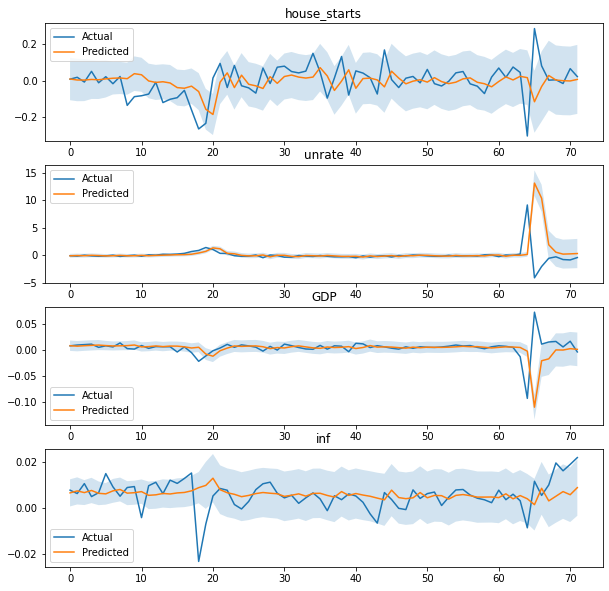

In [76]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for var in range(data.shape[1]):
  axs[var].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var].plot(preds_all[:, var], label='Predicted')
  
  # Draw the 95% confidence interval
  axs[var].fill_between(np.arange(test_size), preds_all[:, var] - 1.96*vol_all[:, var], preds_all[:, var] + 1.96*vol_all[:, var], alpha=0.2)
  
  axs[var].set_title(data.columns[var])
  axs[var].legend()

In [77]:
# Save preds_all and vol_all
np.save('SVol Benchmarks/arfit_all_quarterly_4var_ar2_constvol.npy', preds_all)
np.save('SVol Benchmarks/svfit_all_quarterly_4var_ar2_constvol.npy', vol_all)

### Monthly

In [3]:
data = pd.read_csv('SVol Benchmarks/monthlyData_updated.csv')
data = data[['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']]
test_size = 180
window_size = 180

In [5]:
preds_all = np.zeros((test_size, 7))
vol_all = np.zeros((test_size, 7))

In [6]:
for var in range(data.shape[1]):
  for t in range(test_size):
    # Create a training set of size window_size
    y_train = data.iloc[(len(data) - test_size + t - window_size):(len(data) - test_size + t), var]
    # Concat the two lags to get the training set
    Y_train = pd.DataFrame(np.vstack((y_train, y_train.shift(1), y_train.shift(2))).T).dropna()
    Y_train.columns = ['y', 'y_lag1', 'y_lag2']
    X_train = Y_train[['y_lag1', 'y_lag2']]
    y_train = Y_train['y']

    # Run a regression
    # Add constant term
    X_train = sm.add_constant(X_train)
    # Fit the model - use X to predict y
    model = sm.OLS(y_train, X_train).fit()
    # Get the residuals in the training set
    resid_train = model.resid
    # Get the SD of the residuals
    sd_resid = np.std(resid_train)
    # Make predictions 
    X_test = np.array(Y_train.iloc[-1, :2]).reshape(1,-1)
    # Concat a 1 to the end
    X_test = np.hstack((np.ones((1,1)), X_test))
    Y_test_pred = model.predict(X_test)
    
    preds_all[t, var] = Y_test_pred
    vol_all[t, var] = sd_resid

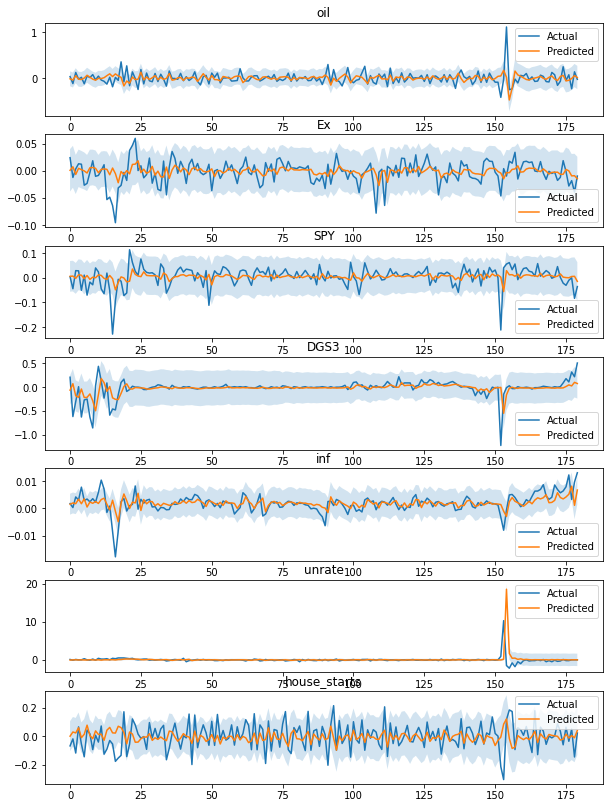

In [11]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(7, 1, figsize=(10, 14))
for var in range(data.shape[1]):
  axs[var].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var].plot(preds_all[:, var], label='Predicted')
  
  # Draw the 95% confidence interval
  axs[var].fill_between(np.arange(test_size), preds_all[:, var] - 1.96*vol_all[:, var], preds_all[:, var] + 1.96*vol_all[:, var], alpha=0.2)
  
  axs[var].set_title(data.columns[var])
  axs[var].legend()

In [12]:
# Save preds_all and vol_all
np.save('SVol Benchmarks/arfit_all_monthly_feb_ar2_constvol.npy', preds_all)
np.save('SVol Benchmarks/svfit_all_monthly_feb_ar2_constvol.npy', vol_all)

### BVAR Benchmark

In [40]:
# Mean predictions
preds_all = pyreadr.read_r(f'SVol Benchmarks/y_pred_all_quarterly_4var_bvar_hor1.RData')['y_pred_hor1'].to_numpy().T
# SD predictions
vol_all = pyreadr.read_r(f'SVol Benchmarks/y_sd_all_quarterly_4var_bvar_hor1.RData')['y_sd_hor1'].to_numpy().T

In [42]:
data = pd.read_csv('SVol Benchmarks/quarterlyData_updated.csv')
data = data[['house_starts', 'unrate', 'GDP', 'inf']]
test_size = 72

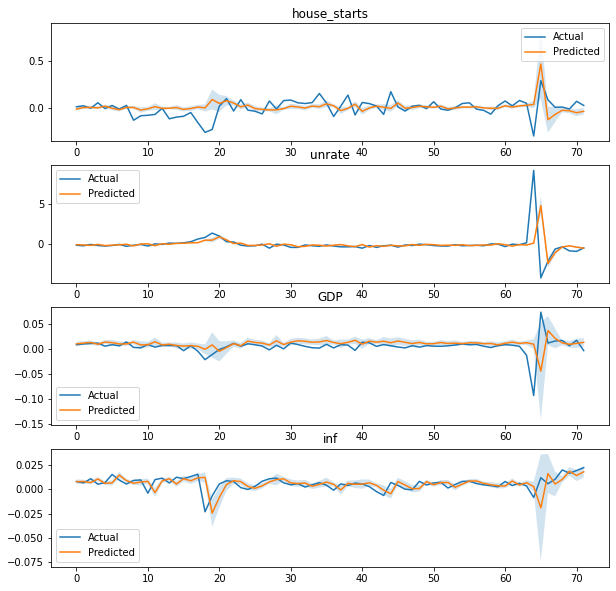

In [43]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for var in range(data.shape[1]):
  axs[var].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var].plot(preds_all[:, var], label='Predicted')
  
  # Draw the 95% confidence interval
  axs[var].fill_between(np.arange(test_size), preds_all[:, var] - 1.96*vol_all[:, var], preds_all[:, var] + 1.96*vol_all[:, var], alpha=0.2)
  
  axs[var].set_title(data.columns[var])
  axs[var].legend()

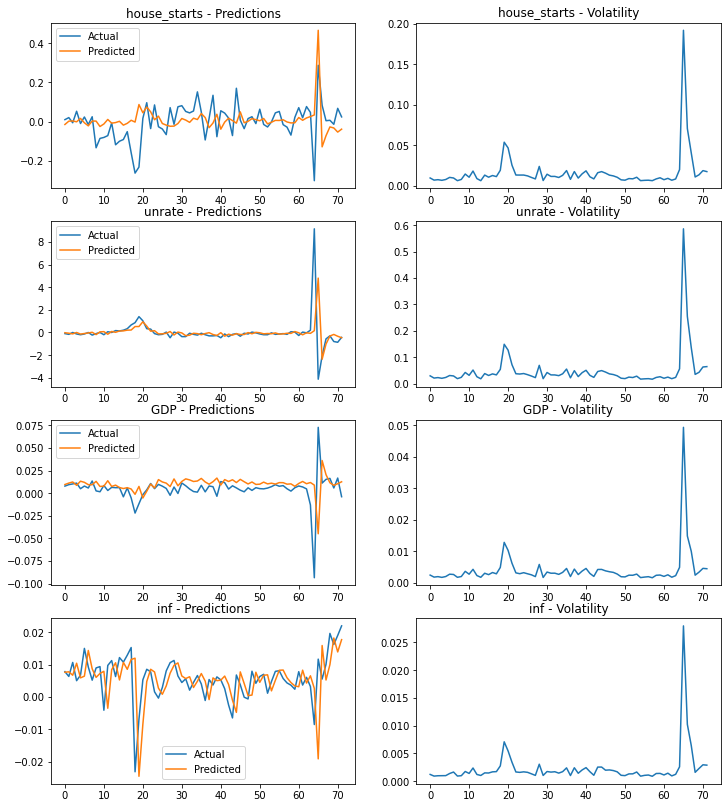

In [49]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(4, 2, figsize=(12, 14))
for var in range(data.shape[1]):
  axs[var,0].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var,0].plot(preds_all[:, var], label='Predicted')
  
  axs[var,1].plot(vol_all[:, var])
  
  axs[var, 0].set_title(data.columns[var] + ' - Predictions')
  axs[var, 1].set_title(data.columns[var] + ' - Volatility')
  axs[var, 0].legend()